## Optimization

The optimization problem is best described as the search of a local maximum or minimum value of a scalar-valued function $f(x)$.  This search may be performed for all possible input values in the domain of $f$ (and in this case we refer to this problem as an *unconstrained optimization*), or for a specific sub-domain (and we refer to this other problem as a *constrained optimization*).  In this section we are going to explore both modalities in several settings.

### Unconstrained Optimization for univariate functions

We focus on the search for local minima of a function $f(x)$ in an interval $[a, b]$ (the search for local maxima can then be regarded as the search of the local minima of the function $-f(x)$ in the same interval).  For this task, we have the routine `minimize_scalar` in the module `scipy.optimize`.  It accepts as obligatory input a univariate function $f(x)$, together with a search method.

Most search methods are based on the idea of _bracketing_ that we used for root finding, although the concept of bracket is a bit different in this setting: In this case, a good _bracket_ is a triple $x < y < z$ where $f(y)$ is less than both $f(x)$ and $f(z)$.  If the function is continuous, its graph presents a U-shape on a bracket.  This guarantees the existence of a minimum inside of the sub-interval $[x, z]$.  A successful bracketing method will look, on each successive step, for the target extremum in either $[x, y]$, or $[y, z]$.

Let us construct a fast bracketing method for testing purposes:  Assume we have as initial bracket $a < c < b$.  By quadratic interpolation, we construct a parabola through the points $\big(a, f(a)\big)$, $\big(c, f(c)\big)$ and $\big(b, f(b)\big)$.  Because of the U-shape condition, there must be a minimum (easily computable) for the interpolating parabola, say $\big(d, f(d)\big)$.  It is not hard to prove that the value $d$ lies between the midpoints of the subintervals $[a, c]$, and $[c, b]$.  We will use this point $d$ for our next bracketing step.  For example, if it happens that $c < d$, then the next bracket will be either $c < d < b$, or $a < c < d$.   Easy enough. let us implement this method:

In [7]:
import numpy as np
from scipy.interpolate import lagrange
from scipy.optimize import OptimizeResult, minimize_scalar

def good_bracket(func, bracket):
    a, c, b = bracket
    return (func(a) > func(c)) and (func(b) > func(c))


def parabolic_step(f, args, bracket, **options):
    stop = False
    funcalls = 0
    niter = 0
    while not stop:
        niter += 1
        interpolator = lagrange(np.array(bracket), f(np.array(bracket)))
        funcalls += 3
        a, b, c = interpolator.coeffs
        d = -0.5*b/a
        if np.allclose(bracket[1], d):
            minima = d
            stop = True
        elif bracket[1] < d:
            newbracket = [bracket[1], d, bracket[2]]
            if good_bracket(f, newbracket):
                bracket = newbracket
            else:
                bracket = [bracket[0], bracket[1], d]
        else:
            newbracket = [d, bracket[1], bracket[2]]
            if good_bracket(f, newbracket):
                bracket = newbracket
            else:
                bracket = [bracket[0], d, bracket[1]]
    return OptimizeResult(fun=f(minima), x=minima, nit=niter, nfev=funcalls)

> The output of any minimizing method must be an `OptimizeResult` object, with at least the attribute `x` (the solution to the optimization problem).  In the example we have just run, the attributes coded in this method are `x`, `fun` (the evaluation of `f` at that solution), `nit` (number of iterations), and `nfev` (number of functions evaluations needed).

Let us run this method over a few examples:

In [8]:
def g(x): return -np.exp(-x)*np.sin(x)

f = np.vectorize(lambda x: max(1-x, 2+x))

print good_bracket(f, [-1, -0.5, 1])

print minimize_scalar(f, bracket=[-1, -0.5, 1], method=parabolic_step)

True
  fun: array(1.5000021457670878)
 nfev: 33
  nit: 11
    x: -0.50000214576708779


In [9]:
print good_bracket(g, [0, 1.2, 1.5])

print minimize_scalar(g, bracket=[0,1.2,1.5], method=parabolic_step)

True
  fun: -0.32239694192707441
 nfev: 54
  nit: 18
    x: 0.78540558550495643


There are two methods already coded for univariate scalar minimization: `golden`, using a *golden section search*, and `brent`, following an algorithm by Brent and Dekker. 

In [10]:
minimize_scalar(f, method='brent', bracket=[-1, -0.5, 1])

  fun: array(1.5)
 nfev: 22
  nit: 21
    x: -0.5

In [11]:
minimize_scalar(f, method='golden', bracket=[-1, -0.5, 1])

  fun: array(1.5)
    x: -0.5
 nfev: 44

In [12]:
minimize_scalar(g, method='brent', bracket=[0, 1.2, 1.5])

  fun: -0.32239694194483443
 nfev: 11
  nit: 10
    x: 0.78539817180087257

In [14]:
minimize_scalar(g, method='golden', bracket=[0, 1.2, 1.5])

  fun: -0.32239694194483448
    x: 0.7853981573284226
 nfev: 43

### Constrained Optimization for univariate functions

Although the bracket included in the routine `minimize_scalar` already places a constraint on the function, it is feasible to force the search for a true minimum inside of a suitable interval for which no bracket can be easily found.


In [15]:
minimize_scalar(g, method='bounded', bounds=(0, 1.5))

  status: 0
    nfev: 10
 success: True
     fun: -0.32239694194483415
       x: 0.78539813414299553
 message: 'Solution found.'

### Unconstrained Optimization for multivariate functions

Except in the case of minimization by brute force or _basin hopping_, we may perform all other searches with the common routine `minimize` from the module `scipy.optimize`.  The parameter `method`, as with its univariate counterpart, takes care of selecting the algorithm employed to achieve the extremum.   There are several well-known algorithms already coded, but we also have the possibility of implementing our own ideas via a suitable custom-made method. 

In this section we will focus on the description and usage of the black-box implementations.  The same technique that we employed in the construction of custom methods for `minimize_scalar` is valid here, with the obvious challenges that the extra dimensions bring.

To compare all the different methods, we are going to run them against a particularly challenging function: Rocksenbrock's _parabolic valley_ (also informally referred to as the _banana function_).  The module `scipy.optimize` has `numpy` versions of this function, as well as its Jacobian and Hessian.


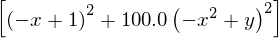

In [17]:
from scipy.optimize import rosen

from sympy import var, Matrix, solve, init_printing
init_printing()

var('x y')

F = Matrix([rosen([x, y])])

F

Let us use techniques from multivariate Calculus to find the critical points of this function.  We need first to compute its Jacobian and Hessian:


In [18]:
JacF = F.jacobian([x, y])
JacF

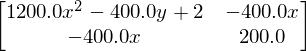

In [19]:
HesF = JacF.jacobian([x, y])
HesF

In [20]:
solve(JacF)

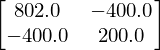

In [21]:
HesF.subs({x: 1.0, y: 1.0})

In [22]:
_.det()

These computations show that there is only one critical point at $(1, 1)$.  Unequivocally, this point presents a local minimum at that location.  

Trying to compute the critical points with this technique for a Rosenbrock function in higher dimensions, while doable, is computationally intense.  Moving to four dimensions, for example, takes a decent computer about half a minute.

In [23]:
var('x:4')
X = [x0, x1, x2, x3]
F = Matrix([rosen(X)])

%time solve(F.jacobian(X))

CPU times: user 25.8 s, sys: 188 ms, total: 26 s
Wall time: 25.9 s


For large dimensions, the search for global minima can be done by brute force: not very elegant, but it gets the job done.  Brute force algorithm is able to track global minima (or approximate it to satisfactory precision).  We can call this method with the routine `brute` in the module `scipy.optimize`.  The obligatory parameters are the function to be minimized, together with a description of the domain where we will apply the optimization.  This domain is best coded as a tuple of slices. For example, to search for a global minimum of the Rosenbrock function in four variables, where each variable is bounded in absolute value by 3, we could issue:

In [24]:
from scipy.optimize import brute

interval = slice(-3, 3, 0.25)
box = [interval] * 4

%time brute(rosen, box)

CPU times: user 3.78 s, sys: 50.1 ms, total: 3.83 s
Wall time: 3.82 s


array([ 1.,  1.,  1.,  1.])

Still quite slow process. To achieve speed, it is always better to use iterative methods.  The search for minima in this setting in achieved according to several schema (and combinations of these):

* Stochastic methods: These are methods suitable for the search of actual global minima. They generate and use random variables.  In the module `scipy.optimize` we have two exponents of this category: 

    * The *Basin-hopping algorithm*, called with the routine `basinhopping` in the module `scipy.optimize`.  The implementation has acceptance test given by the *Metropolis criterion* of a standard Monte-Carlo.
    * A deprecated version of the method of *simulated annealing*, called with `method='Anneal'`, which is a variation of a *Monte-Carlo simulation*.  It is useful for optimization problems where the search space is discrete and large.

* Deterministic algorithms that employ exclusively function evaluations: These are basically performed by successive linear minimizations on different directions.  In the module `scipy.optimize` we have three methods complying with this philosophy:

    * *Powell's method* based on the unidimensional Brent's minimization.  We call it with `method='Powell'`.
    * *Downhill symplex algorithm*.  Also known as the *amoeba method*, created by Nelder and Mead in 1965.  We call it with `'Nelder-Mead'`.

* *Newton methods*: deterministic algorithms on differentiable functions that mimic multivariate Calculus to search for critical points.  In a nutshell, we seek for at least one critical point whose Hessians satisfies the conditions for local minimum.  These algorithms employ both Jacobian and Hessian evaluations.  Because of the complexity of these expressions in general, approximations to both operators are usually implemented instead. When this is the case, we refer to these methods as *quasy-Newton methods*.  In the module `scipy.optimize` we have the quasy-Newton method of Broyden, Fletcher, Goldfarb and Shanno (*BFGS*), that uses exclusively first derivatives.  We call it with `method='BFGS'`.

* *Conjugate gradient* methods.  We have three variants:

    * A variant of the Fetcher-Reeves algorithm to implement a pure conjugate gradient, written by Polak and Ribiere.  It uses exclusively first derivatives.   It is called with `method='CG'`.
    * A combination of conjugate gradient with a Newton method, the *truncated Newton method*, which we call with `method='Newton-CG'`.
    * Two different versions of the *Newton conjugate gradient trust-region algorithm* which use the idea of *trust-regions* to more effectively bound the location of the possible minima.  We call them with `method='dogleg'` and `method='trust-ncg'`.

Let us browse through these methods:

#### Stochastic Methods

Let us find the global minimum of the Rosenbrock function of nine variables using the technique of _basin hopping_:

In [25]:
from scipy.optimize import minimize, basinhopping

%time basinhopping(rosen, np.zeros(9))

CPU times: user 1.32 s, sys: 2.94 ms, total: 1.32 s
Wall time: 1.32 s


                  nfev: 76126
 minimization_failures: 48
                   fun: 3.082225936107851e-11
                     x: array([ 0.99999994,  0.99999989,  0.99999983,  0.9999997 ,  0.99999939,
        0.99999878,  0.99999763,  0.99999529,  0.99999062])
               message: ['requested number of basinhopping iterations completed successfully']
                  njev: 6869
                   nit: 100

Let us compare to the behavior of (the deprecated) _simulated annealing_:

In [26]:
minimize(rosen, np.zeros(9), method='Anneal')

  status: 5
 success: False
  accept: 16
    nfev: 701
       T: 538569677.05593729
     fun: 3201391284.5616984
       x: array([-16.84050345,  -9.61096657,  10.58927389,   1.839771  ,
       -31.88284035, -41.52800697, -31.55791189,  71.50186694, -69.15961597])
 message: 'Final point not the minimum amongst encountered points'
     nit: 13

#### Deterministic Algorithms that employ exclusively function evaluations

Let us compare the results of Powell method with the downhill symplex method:

In [27]:
minimize(rosen, np.zeros(9), method='Powell')

  status: 0
 success: True
   direc: array([[ -9.72738082e-06,   2.08442100e-05,   2.06470354e-05,
          4.39487336e-05,   1.29109965e-04,   1.98333214e-04,
          3.66992710e-04,   7.00645876e-04,   1.38618490e-03],
       [ -6.95913467e-06,  -7.25642319e-07,  -2.39771165e-06,
          4.10148950e-06,  -6.17293950e-06,  -6.53887929e-06,
         -1.06472131e-05,  -5.23030560e-06,  -2.28609237e-06],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.23259263e-06,   9.30817415e-07,   2.48075487e-07,
         -7.07908007e-07,  -2.01233140e-07,  -1.10513436e-06,
         -2.57164632e-06,  -2.58316855e-06,  -3.89962720e-06],
       [  6.07328675e-02,   8.51817777e-02,   1.30174960e-01,
          1.71511253e-01,   9.72602622e-02,   1.47866889e-02,
          1.12376083e-03,   5.35386263e-04,   2.04473740e-04],
       [  0.00000000e+00,   

In [28]:
minimize(rosen, np.zeros(9), method='Nelder-Mead')

  status: 1
    nfev: 1800
 success: False
     fun: 4.9724099905503065
       x: array([ 0.85460488,  0.70911132,  0.50139591,  0.24591886,  0.06234451,
       -0.01112426,  0.02048509,  0.03266785, -0.01790827])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 1287

#### Broyden-Fletcher-Goldfarb-Shanno quasy-Newton method

Let us observe the behavior of this algorithm on our running example:

In [29]:
minimize(rosen, np.zeros(9), method='BFGS')

   status: 0
  success: True
     njev: 81
     nfev: 891
 hess_inv: array([[  1.77754361e-03,   9.43372311e-04,   4.10987819e-04,
          2.36687546e-04,   3.01003165e-04,   4.76269615e-04,
          8.60789342e-04,   1.71519773e-03,   3.52598920e-03],
       [  9.43372311e-04,   1.91424549e-03,   1.05504866e-03,
          7.47730664e-04,   9.79295044e-04,   1.68203806e-03,
          3.21722948e-03,   6.35411625e-03,   1.26594184e-02],
       [  4.10987819e-04,   1.05504866e-03,   2.09554069e-03,
          1.60097649e-03,   1.98173552e-03,   3.40273952e-03,
          6.50440152e-03,   1.28373929e-02,   2.54841319e-02],
       [  2.36687546e-04,   7.47730664e-04,   1.60097649e-03,
          3.24398082e-03,   3.87135490e-03,   6.39636277e-03,
          1.22541796e-02,   2.42557510e-02,   4.82857024e-02],
       [  3.01003165e-04,   9.79295044e-04,   1.98173552e-03,
          3.87135490e-03,   7.61753726e-03,   1.26819289e-02,
          2.42445571e-02,   4.80072031e-02,   9.56010467e-0

Note that it employs more iterations, but much fewer function evaluations than the method of Powell (including Jacobian evaluations).  Accuracy is comparable, but the gain in complexity and speed in remarkable. 

#### Conjugate Gradient Methods

The pure Conjugate Gradient method works best with functions with a clear unique critical point, and where the range of the slopes is not too large.  Multiple stationary points tend to confuse the iterations, and slopes too steep (larger than 1000) result in terrible rounding errors.

Without offering an expression for the Jacobian, the algorithm computes a decent approximation of this operator to compute the first derivatives.


In [30]:
minimize(rosen, np.zeros(9), method='CG')

  status: 0
 success: True
    njev: 435
    nfev: 4786
     fun: 7.4275163638423293e-12
       x: array([ 0.99999996,  0.99999994,  0.9999999 ,  0.99999984,  0.9999997 ,
        0.99999941,  0.99999884,  0.9999977 ,  0.99999541])
 message: 'Optimization terminated successfully.'
     jac: array([  1.68619156e-06,  -5.75213410e-07,   4.39290699e-09,
         3.25975705e-06,   3.14717890e-06,   4.16568319e-06,
         2.80213772e-06,   2.20476712e-06,   3.22092180e-06])

Including an actual Jacobian improves matters greatly.  Note the improvement in the evaluation of the found minimum (`fun`):


In [31]:
from scipy.optimize import rosen_der

minimize(rosen, np.zeros(9), method='CG', jac=rosen_der)

  status: 0
 success: True
    njev: 346
    nfev: 346
     fun: 3.0359274125581914e-11
       x: array([ 0.99999995,  0.99999992,  0.99999984,  0.99999969,  0.99999941,
        0.99999883,  0.99999764,  0.99999524,  0.99999046])
 message: 'Optimization terminated successfully.'
     jac: array([ -3.90312446e-06,  -6.85277639e-07,  -3.48274672e-06,
        -7.85146149e-06,  -1.83331671e-06,   5.17866611e-06,
         6.14648734e-06,  -5.09552972e-06,  -5.53195416e-06])

The _truncated Newton method_ requires a precise Jacobian to work:

In [32]:
minimize(rosen, np.zeros(9), method='Newton-CG')

ValueError: Jacobian is required for Newton-CG method

In [33]:
minimize(rosen, np.zeros(9), method='Newton-CG', jac=rosen_der)

  status: 0
 success: True
    njev: 491
    nfev: 52
     fun: 8.93568453398332e-08
       x: array([ 0.99999908,  0.99999814,  0.9999962 ,  0.99999208,  0.99998296,
        0.99996124,  0.99990407,  0.99980315,  0.99960355])
 message: 'Optimization terminated successfully.'
    nhev: 0
     jac: array([  1.05256767e-06,   4.93943521e-06,   3.07570546e-05,
         1.26616368e-04,   5.00086255e-04,   1.99370744e-03,
         7.92927982e-03,   3.14633540e-02,  -1.82127839e-02])

The methods using trust regions require an exact expression for the Hessian:

In [34]:
from scipy.optimize import rosen_hess

minimize(rosen, np.zeros(9), method='dogleg', jac=rosen_der, hess=rosen_hess)

  status: 0
    hess: array([[  801.99999999,  -400.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [ -400.        ,  1001.99999998,  -399.99999999,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,  -399.99999999,  1001.99999996,  -399.99999999,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,  -399.99999999,  1001.99999992,
         -399.99999998,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,     0.        ,  -399.99999998,
         1001.99999983,  -399.99999996,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
         -399.99999996,  1001.99999967,  -399.99999992,     0

In [35]:
minimize(rosen, np.zeros(9), method='trust-ncg', jac=rosen_der, hess=rosen_hess)

  status: 0
    hess: array([[  801.99999999,  -400.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [ -400.        ,  1001.99999999,  -400.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,  -400.        ,  1001.99999998,  -399.99999999,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,  -399.99999999,  1001.99999995,
         -399.99999999,     0.        ,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,     0.        ,  -399.99999999,
         1001.9999999 ,  -399.99999998,     0.        ,     0.        ,
            0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
         -399.99999998,  1001.99999981,  -399.99999995,     0

Note the huge improvement in terms of accuracy, iterations, and function evaluations over the previous methods!  The obvious drawback is that quite often it is very challenging to obtain good representations of the Jacobian or Hessian operators.

### Constrained Optimization for multivariate functions

Take for example, the minimization of the plane $f(x,y) = 5x-2y+4$ over the circle $x^2+y^2 =4$.  Using `sympy` we could implement the technique of Lagrange multipliers:

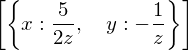

In [36]:
F = Matrix([5*x - 2*y + 4])
G = Matrix([x**2 + y**2 - 4])      # constraint

var('z')

solve(F.jacobian([x, y]) - z * G.jacobian([x, y]))

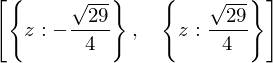

In [37]:
soln = _[0]
solve(G.subs(soln))

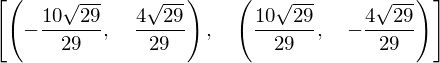

In [38]:
zees = _
[(soln[x].subs(item), soln[y].subs(item)) for item in zees]

Not too bad.  If, on top of this constraint, we further impose another one in the form of an inequality, more involved mathematics need to be used.  Think of the same problem, but constraining to half a circle instead: $y > 0$.  This being the case, the new result will be only the point with coordinates $x = -10\sqrt{29}/29 = -1.8569533817705186$ and $y = 4\sqrt{29}/29 = 0.74278135270820744$.

It is of course possible to address this problem numerically.  In the module `scipy.optimize` we have basically three methods, all of which may be called from the common routine `minimize`: 

* *Large-scale Bound-constrained Optimization* based on the BFGS algorithm (we call it with `method='L-BFGS-B'`).  The implementation is actually a wrapper to a `Fortran` routine with the same name, written by Ciyou Zhu, Richard Byrd, and Jorge Nocedal. (for details, see e.g. R. H. Byrd, P. Lu and J. Nocedal. _A Limited Memory Algorithm for Bound Constrained Optimization_, (1995), SIAM Journal on Scientific and Statistical Computing, 16, 5, pp. 1190-1208.) 
* A constrained-based algorithm based on the truncated Newton method (we call it with `method='TNC'`).  This implementation is similar to the one we called with `method='Newton-CG'`, except this version is a wrapper to a `C` routine.
* *Constrained Optimization by Linear Approximation* (with `method='COBYLA'`).  This implementation wraps a `Fortran` routine with the same name.
* A minimization method based on *Sequential Least Squares Programming* (`method='SLSQP'`).  The implementation is a wrapper to a `Fortran` routine with the same name, written by Dieter Kraft.

Let us use our running problem to illustrate how to input different constraints.  We implement these as a dictionary, or a tuple of dictionaries: each entry in the tuple represents either an identity (`'eq'`) or an inequality (`'ineq'`), together with a functional expression (in the form of a `ndarray` when necessary) and corresponding derivative of it. 


In [39]:
def f(x): return 5*x[0] - 2*x[1] + 4
def jacf(x): return np.array([5.0, -2.0])

circle = {'type': 'eq',
          'fun': lambda x: x[0]**2 + x[1]**2 - 4.0,
          'jac': lambda x: np.array([2.0 * x[0], 2.0 * x[1]])}

semicircle = ({'type': 'eq',
               'fun': lambda x: x[0]**2 + x[1]**2 - 4.0,
               'jac': lambda x: np.array([2.0 * x[0], 2.0 * x[1]])},
              {'type': 'ineq',
               'fun': lambda x: x[1],
               'jac': lambda x: np.array([0.0, 1.0])})

The constraints are fed to the routine `minimize` through the parameter `constraints`.  The initial guess must satisfy the constraints, of course.

In [40]:
minimize(f, [2,2], jac=jacf, method='SLSQP', constraints=circle)

  status: 0
 success: True
    njev: 11
    nfev: 13
     fun: -6.7703296142789693
       x: array([-1.85695338,  0.74278135])
 message: 'Optimization terminated successfully.'
     jac: array([ 5., -2.,  0.])
     nit: 11

In [41]:
minimize(f, [2,2], jac=jacf, method='SLSQP', constraints=semicircle)

  status: 0
 success: True
    njev: 11
    nfev: 13
     fun: -6.7703296142789693
       x: array([-1.85695338,  0.74278135])
 message: 'Optimization terminated successfully.'
     jac: array([ 5., -2.,  0.])
     nit: 11